In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import Normalize

from torchvision.ops import distance_box_iou_loss
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, DataLoader, TensorDataset

from tqdm import tqdm
import pickle

In [2]:
seed = 265
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
torch.manual_seed(seed)
print(f'Selected device: {device}')

Selected device: cuda


## Data loading and preprocessing

Need to load data, normalize, preprocess labels and create dataset.



In [3]:
def load_data():
    # return only the first tensor so that we can preprocess the labels
    train_data = torch.load('data/detection_train.pt').tensors[0]
    val_data = torch.load('data/detection_val.pt').tensors[0]
    test_data = torch.load('data/detection_test.pt').tensors[0]

    # un-processed labels
    train_labels = torch.load('data/list_y_true_train.pt')
    val_labels = torch.load('data/list_y_true_val.pt')
    test_labels = torch.load('data/list_y_true_test.pt')

    return train_data, train_labels, val_data, val_labels, test_data, test_labels
train_data, train_labels, val_data, val_labels, test_data, test_labels = load_data()

In [4]:
#Getting the mean and std value of training and creating a normalizer
def normalize_data(data):
    return transforms.Normalize(mean=torch.mean(train_data, axis=(0, 2, 3)), std=torch.std(train_data, axis=(0, 2, 3)))(data)

In [5]:
#Normalizing the data
normalized_train = normalize_data(train_data)
normalized_val = normalize_data(val_data)
normalized_test = normalize_data(test_data)

In [6]:
#Sanity check
print('Train mean, std :',normalized_train.mean(), normalized_train.std())
print('Train mean, std :',normalized_val.mean(), normalized_val.std())
#Dont want to look at test yet. As long as we know that we only normalized on training

Train mean, std : tensor(-1.2770e-07) tensor(1.)
Train mean, std : tensor(-0.0045) tensor(0.9961)


In [7]:
#Takes in bounding box with global cords and transform it to local cell cords
def convert_to_local(t):
    x_global, y_global, w_global, h_global = t[1:-1]

    if y_global <= 0.5:
        row = 0
        grid_y = 0
    else:
        row = 1
        grid_y = 0.5

    if x_global < 1/3:
        col = 0
        grid_x = 0
    elif 1/3 <= x_global <= 2/3:
        col = 1
        grid_x = 1/3
    else:
        col = 2
        grid_x = 2/3

    x_local = (x_global - grid_x) * 3

    y_local = (y_global - grid_y) * 2

    w_local = w_global * 3
    h_local = h_global * 2

    return row, col, torch.tensor([t[0], x_local, y_local, w_local, h_local, t[-1]])

In [8]:
#Need to process all the data. Could use tensor operations, but runtime on desktop is suffiecient enough. Runtime is estimated to be around O(n^2) to O(nlogn)
#We only need to run this before training, and not during. 
def process_all(labels):
    new_tensor = torch.zeros(len(labels), 2, 3, 6)
    for idx, t1 in enumerate(labels):
        for t2 in t1:
            if t2[0] == 1:
                row, col, coords_tensor = convert_to_local(t2)
                new_tensor[idx, row, col, :] = coords_tensor
    return new_tensor

In [9]:
train_labels_p = process_all(train_labels)
val_labels_p = process_all(val_labels)
test_labels_p = process_all(test_labels)

In [10]:
train_labels_p.shape

torch.Size([26874, 2, 3, 6])

## Data exploration of self-preprocessed data

In [11]:
print(f'Size of training set: {len(normalized_train)}')
print(f'Size of validation set: {len(normalized_val)}')
print(f'Size of test set: {len(normalized_test)}')
print()

train_labels_objects_only = (train_labels_p[train_labels_p[:,:,:,0] == 1])
vals, counts = torch.unique(train_labels_objects_only[:,-1], return_counts=True)
print(f'Image size: {train_data.shape}')
print(f'Possible labels in the dataset: {int(vals[0])}: {counts[0]}, {int(vals[1])}: {counts[1]}')

print()

print('Counts of different amount of objects in the data:')

no_objects = len(train_labels_p[torch.where(train_labels_p[:,:,:,0].sum(dim=2).sum(dim=1) == 0)])
one_object = len(train_labels_p[torch.where(train_labels_p[:,:,:,0].sum(dim=2).sum(dim=1) == 1)])
two_objects = len(train_labels_p[torch.where(train_labels_p[:,:,:,0].sum(dim=2).sum(dim=1) == 2)])
three_objects = len(train_labels_p[torch.where(train_labels_p[:,:,:,0].sum(dim=2).sum(dim=1) == 3)])
four_objects = len(train_labels_p[torch.where(train_labels_p[:,:,:,0].sum(dim=2).sum(dim=1) == 4)])
five_objects = len(train_labels_p[torch.where(train_labels_p[:,:,:,0].sum(dim=2).sum(dim=1) == 5)])
print(f'Amount of images with 0 objects: {no_objects}')
print(f'Amount of images with 1 object: {one_object}')
print(f'Amount of images with 2 objects: {two_objects}')
print(f'Amount of images with 3 objects: {three_objects}')
print(f'Amount of images with 4 objects: {four_objects}')
print(f'Amount of images with 5 objects: {five_objects}')

print(f'Total: {np.sum([one_object, two_objects, three_objects, four_objects])}')


Size of training set: 26874
Size of validation set: 2967
Size of test set: 4981

Image size: torch.Size([26874, 1, 48, 60])
Possible labels in the dataset: 0: 16035, 1: 18225

Counts of different amount of objects in the data:
Amount of images with 0 objects: 0
Amount of images with 1 object: 19859
Amount of images with 2 objects: 6650
Amount of images with 3 objects: 359
Amount of images with 4 objects: 6
Amount of images with 5 objects: 0
Total: 26874


## Training examples:

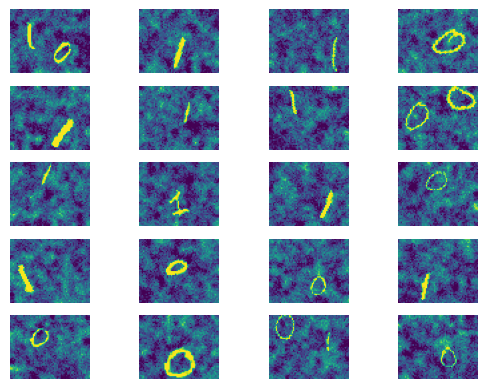

In [12]:
def show_examples():
    fig, ax = plt.subplots(5, 4)
    ax = ax.flatten()
    for i in range(20):
        ax[i].imshow(normalized_train[i].permute(1, 2, 0))
        ax[i].axis('off')

show_examples()

## Training examples with bounding boxes

#### We first have to convert the local data back to global coordinates

In [13]:
# Function to convert everything in a tensor to global coordinates
def convert_to_global(t):
    ls_results = []

    objs, local_x, local_y, local_w, local_h = t[:,:,:,0], t[:,:,:,1], t[:,:,:,2], t[:,:,:,3], t[:,:,:,4]


    for label in t:
        sub_list = []
        indices = torch.nonzero(label[:,:,0] == 1)
        indices = tuple((indices.tolist()))
        for idx in indices:
            instance = label[idx[0], idx[1], :]
            converted = convert_single_global(instance, idx)
            sub_list.append(converted)

        ls_results.append(sub_list)
    return ls_results

In [14]:
# Function to convert a single line to a tensor based on input index
def convert_single_global(t, idx):
    row, col = idx

    x_local, y_local, w_local, h_local = t[1:-1]

    x_global = (x_local + col) / 3
    y_global = (y_local + row) / 2

    w_global = w_local / 3
    h_global = h_local / 2

    return torch.tensor([t[0], x_global, y_global, w_global, h_global, t[-1]])


In [15]:
def draw_bounding(data, labels, idx, predictions=None, local=True, show_img=True):
    # If data with local coordinates is passed in, convert them to global coordinates
    if local:
        labels = convert_to_global(labels)

    #Scale the image so it is compatible with draw bounding boxes
    data_point = (data[idx]*255).to(torch.uint8)

    data_label = labels[idx]

    #Create an empty shell for box convert. And convert to propper format
    bboxes_true = torch.zeros(len(data_label), 4)

    for i, label in enumerate(data_label):
        bbox = label[1:-1]

        x_min = (bbox[0] - bbox[2] / 2) * 60
        y_min = (bbox[1] - bbox[3] / 2) * 48
        x_max = (bbox[0] + bbox[2] / 2) * 60
        y_max = (bbox[1] + bbox[3] / 2) * 48
        converted_bb = torch.stack([x_min, y_min, x_max, y_max])

        bboxes_true[i] = converted_bb

    #If comparison with predictions are passed in. Convert it to propper format
    if predictions is not None:
        prediction_label = predictions[idx]
        bboxes_pred = torch.zeros(len(prediction_label), 4)
        for j, label in enumerate(prediction_label):
            bbox = label[1:-1]

            x_min = (bbox[0] - bbox[2] / 2) * 60
            y_min = (bbox[1] - bbox[3] / 2) * 48
            x_max = (bbox[0] + bbox[2] / 2) * 60
            y_max = (bbox[1] + bbox[3] / 2) * 48
            converted_bb = torch.stack([x_min, y_min, x_max, y_max])

            bboxes_pred[j] = converted_bb

    #Using torchvisions function for drawing bounding boxes
    bbox_img = draw_bounding_boxes(data_point, bboxes_true, colors=(0, 0, 255), fill=True)
    if predictions:
        bbox_img = draw_bounding_boxes(bbox_img, bboxes_pred, colors=(255, 0, 0), fill=True)

    bbox_img = transforms.ToPILImage()(bbox_img)


    if show_img == True:
        plt.imshow(bbox_img)

    return bbox_img

In [16]:
train_labels_g = convert_to_global(train_labels_p)
val_labels_g = convert_to_global(val_labels_p)
test_labels_g = convert_to_global(test_labels_p)

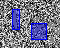

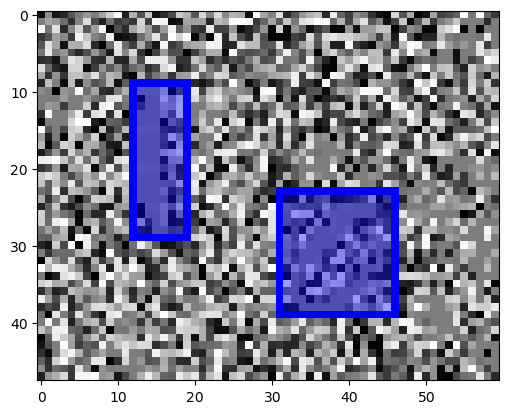

In [17]:
draw_bounding(normalized_train, train_labels_g, 0, local=False)

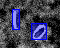

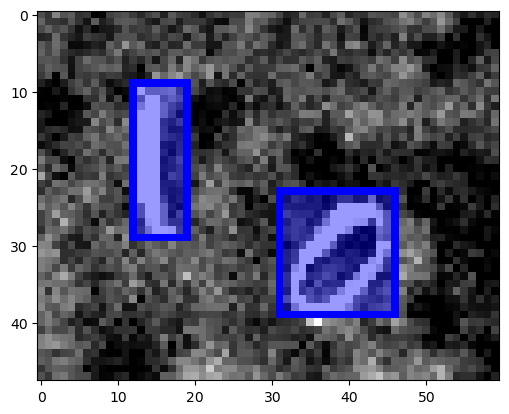

In [18]:
draw_bounding(train_data, train_labels_g, 0, local=False)

## Model architectures

In [19]:
class ShallowCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 12, (3, 3), stride=1, padding=1) # -> 48x60x12
        self.conv2 = nn.Conv2d(12, 12, (3, 3), stride=1, padding=1) # -> 48x60x12
        self.max_pool1 = nn.MaxPool2d((2, 2), stride=2) # -> 24x30x12
        
        self.conv3 = nn.Conv2d(12, 12, (3, 3), stride=1, padding=1) # -> 24x30x12
        self.max_pool2 = nn.MaxPool2d((2, 2), stride=2) # -> 12x15x12
        
        self.conv4 = nn.Conv2d(12, 12, (3, 4), stride=1) # -> 10x12x12
        self.max_pool3 = nn.MaxPool2d((2, 2), stride=2) # -> 5x6x12
        
        self.conv5 = nn.Conv2d(12, 6, (4, 4), stride=1) # -> 2x3x12

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.max_pool1(x)
        
        x = F.relu(self.conv3(x))
        x = self.max_pool2(x)

        x = F.relu(self.conv4(x))
        x = self.max_pool3(x)

        return self.conv5(x)

In [20]:
class MediumCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 24, (5, 5), stride=1, padding=1) # -> 48x60x24
        self.conv2 = nn.Conv2d(24, 24, (3, 3), stride=1, padding=1) # -> 48x60x24
        self.max_pool1 = nn.MaxPool2d((2, 2), stride=2) # -> 24x30x20
        
        self.conv3 = nn.Conv2d(24, 20, (3, 3), stride=1, padding=1) # -> 24x30x20
        self.conv4 = nn.Conv2d(20, 18, (3, 3), stride=1, padding=1) # -> 24x30x18
        self.max_pool2 = nn.MaxPool2d((2, 2), stride=2) # -> 12x15x18
        
        self.conv5 = nn.Conv2d(18, 12, (3, 3), stride=1) # -> 10x13x12
        self.conv6 = nn.Conv2d(12, 12, (3, 4), stride=1, padding=1) # -> 10x12x12
        self.max_pool3 = nn.MaxPool2d((2, 2), stride=2) # -> 5x6x12
        
        self.conv7 = nn.Conv2d(12, 6, (3, 3), stride=1) # -> 2x3x6
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.max_pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.max_pool2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.max_pool3(x)

        return self.conv7(x)

In [21]:
class MediumCNN_bn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 24, (5, 5), stride=1, padding=1) # -> 48x60x24
        self.batchnorm24 = nn.BatchNorm2d(24)
        self.conv2 = nn.Conv2d(24, 24, (3, 3), stride=1, padding=1) # -> 48x60x24
        self.max_pool1 = nn.MaxPool2d((2, 2), stride=2) # -> 24x30x20
        
        self.conv3 = nn.Conv2d(24, 20, (3, 3), stride=1, padding=1) # -> 24x30x20
        self.batchnorm20 = nn.BatchNorm2d(20)
        self.conv4 = nn.Conv2d(20, 18, (3, 3), stride=1, padding=1) # -> 24x30x18
        self.batchnorm18 = nn.BatchNorm2d(18)
        self.max_pool2 = nn.MaxPool2d((2, 2), stride=2) # -> 12x15x18
        
        self.conv5 = nn.Conv2d(18, 12, (3, 3), stride=1) # -> 10x13x12
        self.batchnorm12 = nn.BatchNorm2d(12)
        self.conv6 = nn.Conv2d(12, 12, (3, 4), stride=1, padding=1) # -> 10x12x12
        self.max_pool3 = nn.MaxPool2d((2, 2), stride=2) # -> 5x6x12
        
        self.conv7 = nn.Conv2d(12, 6, (3, 3), stride=1) # -> 2x3x6
        
    def forward(self, x):
        x = F.relu(self.batchnorm24(self.conv1(x)))
        x = F.relu(self.batchnorm24(self.conv2(x)))
        x = self.max_pool1(x)

        x = F.relu(self.batchnorm20(self.conv3(x)))
        x = F.relu(self.batchnorm18(self.conv4(x)))
        x = self.max_pool2(x)

        x = F.relu(self.batchnorm12(self.conv5(x)))
        x = F.relu(self.batchnorm12(self.conv6(x)))
        x = self.max_pool3(x)

        return self.conv7(x)

In [22]:
class DeepCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, (3, 3), stride=1, padding=1) # -> 48x60x16
        self.conv2 = nn.Conv2d(16, 32, (3, 3), stride=1, padding=1) # -> 48x60x32
        self.max_pool1 = nn.MaxPool2d((2, 2), stride=2) # -> 24x30x32
        
        self.conv3 = nn.Conv2d(32, 64, (3, 3), stride=1, padding=1) # -> 24x30x64
        self.conv4 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1) # -> 24x30x64
        self.max_pool2 = nn.MaxPool2d((2, 2), stride=2) # -> 12x15x64
        
        self.conv5 = nn.Conv2d(64, 128, (3, 4), stride=1) # -> 10x12x128
        self.conv6 = nn.Conv2d(128, 128, (3, 3), stride=1, padding=1) # -> 10x12x128
        self.max_pool3 = nn.MaxPool2d((2, 2), stride=2) # -> 5x6x128
        
        self.conv7 = nn.Conv2d(128, 64, (3, 3), stride=1, padding=1) # -> 5x6x64
        self.conv8 = nn.Conv2d(64, 32, (3, 3), stride=1, padding=1) # -> 5x6x32
        self.conv9 = nn.Conv2d(32, 6, (4, 4), stride=1) # -> 2x3x6

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.max_pool1(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.max_pool2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.max_pool3(x)

        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))

        return self.conv9(x)
        

In [23]:
class DeepCNN_bn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, (3, 3), stride=1, padding=1) # -> 48x60x16
        self.batchnorm16 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, (3, 3), stride=1, padding=1) # -> 48x60x32
        self.batchnorm32 = nn.BatchNorm2d(32)
        self.max_pool1 = nn.MaxPool2d((2, 2), stride=2) # -> 24x30x32
        
        self.conv3 = nn.Conv2d(32, 64, (3, 3), stride=1, padding=1) # -> 24x30x64
        self.batchnorm64 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, (3, 3), stride=1, padding=1) # -> 24x30x64
        self.max_pool2 = nn.MaxPool2d((2, 2), stride=2) # -> 12x15x64
        
        self.conv5 = nn.Conv2d(64, 128, (3, 4), stride=1) # -> 10x12x128
        self.batchnorm128 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, (3, 3), stride=1, padding=1) # -> 10x12x128
        self.max_pool3 = nn.MaxPool2d((2, 2), stride=2) # -> 5x6x128
        
        self.conv7 = nn.Conv2d(128, 64, (3, 3), stride=1, padding=1) # -> 5x6x64
        self.conv8 = nn.Conv2d(64, 32, (3, 3), stride=1, padding=1) # -> 5x6x32
        self.conv9 = nn.Conv2d(32, 6, (4, 4), stride=1) # -> 2x3x6

    def forward(self, x):
        x = F.relu(self.batchnorm16(self.conv1(x)))
        x = F.relu(self.batchnorm32(self.conv2(x)))
        x = self.max_pool1(x)
        
        x = F.relu(self.batchnorm64(self.conv3(x)))
        x = F.relu(self.batchnorm64(self.conv4(x)))
        x = self.max_pool2(x)

        x = F.relu(self.batchnorm128(self.conv5(x)))
        x = F.relu(self.batchnorm128(self.conv6(x)))
        x = self.max_pool3(x)

        x = F.relu(self.batchnorm64(self.conv7(x)))
        x = F.relu(self.batchnorm32(self.conv8(x)))

        return self.conv9(x)

## Loss functions

In [26]:
class MCELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
      error = (input - target) ** 3
      return torch.mean(error)

In [27]:
def detection_loss_with_mce(pred_obj, y_obj, pred_bbox, y_bbox, pred_label, y_label):
    l1 = nn.BCEWithLogitsLoss()
    l2 = MCELoss()
    l3 = nn.BCEWithLogitsLoss()

    l1_loss = l1(pred_obj, y_obj)
    l2_loss = l2(pred_bbox, y_bbox) 
    l3_loss = l3(pred_label, y_label)

    return l1_loss + l2_loss + l3_loss

In [28]:
def detection_loss_with_mse(pred_obj, y_obj, pred_bbox, y_bbox, pred_label, y_label):
    l1 = nn.BCEWithLogitsLoss()
    l2 = nn.MSELoss()
    l3 = nn.BCEWithLogitsLoss()

    l1_loss = l1(pred_obj, y_obj)

    mask = pred_obj > 0.5
    
    if mask.any():
        l2_loss = l2(pred_bbox[mask], y_bbox[mask]) 
        l3_loss = l3(pred_label[mask], y_label[mask])
    else:
        l2_loss = torch.tensor(0.0, device=pred_obj.device)
        l3_loss = torch.tensor(0.0, device=pred_obj.device)
        
    return l1_loss + l2_loss + l3_loss

In [29]:
def detection_loss_with_iou(pred_obj, y_obj, pred_bbox, y_bbox, pred_label, y_label):
    l1 = nn.BCEWithLogitsLoss()
    l3 = nn.BCEWithLogitsLoss()

    l1_loss = l1(pred_obj, y_obj)
    l2_loss = distance_box_iou_loss(pred_bbox, y_bbox, reduction='mean')
    l3_loss = l3(pred_label, y_label)

    return l1_loss + l2_loss + l3_loss

In [30]:
def detection_loss_with_l1(pred_obj, y_obj, pred_bbox, y_bbox, pred_label, y_label):
    l1 = nn.BCEWithLogitsLoss()
    l2 = nn.SmoothL1Loss()
    l3 = nn.BCEWithLogitsLoss()

    l1_loss = l1(pred_obj, y_obj)

    mask = pred_obj > 0.5
    
    if mask.any():
        l2_loss = l2(pred_bbox[mask], y_bbox[mask]) 
        l3_loss = l3(pred_label[mask], y_label[mask])
    else:
        l2_loss = torch.tensor(0.0, device=pred_obj.device)
        l3_loss = torch.tensor(0.0, device=pred_obj.device)

    return l1_loss + l2_loss + l3_loss

## Training loop

In [31]:
import time

In [32]:
def train(n_epochs, optimizer, lossfn, model, train_loader, val_loader):

    batch_size = train_loader.batch_size

    # Get number of batches, make a list for training losses, change model mode to training, and zero the gradients.
    n_batch = len(train_loader)
    losses_train = []
    losses_val = []

    optimizer.zero_grad(set_to_none=True)
    model.train()

    # Every epoch compute gradients of the parameters and update them
    for epoch in range(1, n_epochs + 1):
        # Progress bar
        train_progressbar = tqdm(train_loader, desc=f"Epoch: {epoch}", unit="batch", leave=True)

        # Store the total loss for the epoch
        loss_train = 0.0

        model.train()

        # For every batch in the loader
        for imgs, labels in train_progressbar:

            # Send the data to the same device
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            # Compute the inference of the images
            output = model(imgs.float())

            p_c_pred = output[:,0,:,:]
            bbox_pred = output[:, 1:5, :, :].permute(0, 2, 3, 1)
            labels_pred = output[:, -1, :, :]

            # True label - is there an object in the image?
            p_c_true = labels[:, :, :, 0].float()

            bbox_true = labels[:,:,:,1:5]

            labels_true = labels[:, :, :, -1].float()

            
            # Compare the loss between inference and true labels
            loss = lossfn(p_c_pred, p_c_true, bbox_pred, bbox_true, labels_pred, labels_true)
            

            # Find the gradients of loss with respect to gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Zero the gradient
            optimizer.zero_grad()

            # Add the loss
            loss_train += loss.sum().item()

        #Validation
        model.eval()

        loss_val = 0.0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)


                output = model(imgs.float())

                p_c_pred = output[:,0,:,:]
                bbox_pred = output[:, 1:5, :, :].permute(0, 2, 3, 1)
                labels_pred = output[:, -1, :, :]

                # True label - is there an object in the image?
                p_c_true = labels[:, :, :, 0].float()

                # bbox_true = torch.cat((labels[:,:,:,1:3], F.relu(labels[:,:,:,3:5])), dim=3)

                bbox_true = labels[:,:,:,1:5]

                # bbox_true = labels[:,:,:,1:5] #F.sigmoid(labels[:, :, :, 1:5]) # squashing input between 0 and 1 - we don't want negative values for coordinates

                labels_true = labels[:, :, :, -1].float()

                # Compare the loss between inference and true labels
                loss = lossfn(p_c_pred, p_c_true, bbox_pred, bbox_true, labels_pred, labels_true)

                loss_val += loss.item()

        final_val_loss = loss_val / len(val_loader)

        losses_val.append(final_val_loss)

        # Add the loss of the epoch to the list
        the_loss = loss_train / n_batch
        losses_train.append(the_loss)
        print(f"Epoch: {epoch}, Train loss: {the_loss : .3f}, Val loss: {final_val_loss : .3f}")
        train_progressbar.close() # Close the progress bar for the epoch

    return losses_train, losses_val


## Performance measures

In [33]:
def compute_intersection(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    x_inter = max(x1, x2)
    y_inter = max(y1, y2)
    w_inter = min(x1 + w1, x2 + w2) - x_inter
    h_inter = min(y1 + h1, y2 + h2) - y_inter

    if w_inter <= 0 or h_inter <= 0:
        return 0
    else:
        return w_inter * h_inter

In [34]:
def compute_union_area(box1, box2, intersection_area):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    area_box1 = w1 * h1
    area_box2 = w2 * h2

    return area_box1 + area_box2 - intersection_area

In [35]:
def iou(box1, box2):
    intersect = compute_intersection(box1, box2)
    union = compute_union_area(box1, box2, intersect)
    return intersect/union

In [36]:
def compute_accuracy(predictions, target):
    return len(predictions.reshape(-1)[torch.where(predictions.reshape(-1) == target.reshape(-1))]) / len(predictions.reshape(-1))

In [37]:
def compute_iuo(box1, box2):
    
    x1, y1, w1, h1 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    x2, y2, w2, h2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]

    #print(x1,y1, w1, h1)
    #print(box1)

    x_inter = torch.max(x1, x2)
    y_inter = torch.max(y1, y2)
    w_inter = torch.min(x1 + w1, x2 + w2) - x_inter
    h_inter = torch.min(y1 + h1, y2 + h2) - y_inter

    
    w_inter[w_inter <= 0] = 0
    h_inter[h_inter <= 0] = 0
    
    intersection_area = torch.mul(w_inter, h_inter)
    area_box1 = w1 * h1
    area_box2 = w2 * h2

    return intersection_area/(area_box1 + area_box2 - intersection_area)

In [38]:
def final_acc_iou(preds, target):
    p_c_pred = preds[:,:,:,0]
    bbox_pred = preds[:,:,:,1:5][torch.where(p_c_pred == 1)]
    label_pred = preds[:,:,:,-1][torch.where(p_c_pred == 1)]

    p_c_true = target[:,:,:,0]
    bbox_true = target[:,:,:,1:5][torch.where(p_c_pred == 1)]
    label_true = target[:,:,:,-1][torch.where(p_c_pred == 1)]
    
    p_c_acc = len(p_c_pred.reshape(-1)[torch.where(p_c_pred.reshape(-1) == p_c_true.reshape(-1))]) / len(p_c_pred.reshape(-1))

    bbox_iou = compute_iuo(bbox_pred, bbox_true).mean()
    

    label_acc = len(label_pred.flatten()[torch.where(label_pred.flatten() == label_true.flatten())]) / len(label_pred.flatten())



    print(f'Average p_c accuracy: {p_c_acc:.3f}')
    print(f'Average bbox_iou: {bbox_iou:.3f}')
    print(f'Average label_acc: {label_acc:.3f}')

    print(f'Combined: {((p_c_acc + bbox_iou + label_acc) / 3):.3f}')
    return (p_c_acc + bbox_iou + label_acc) / 3

## Function to make output compatible with performance measures

In [39]:
def process_predictions(predictions):
    with torch.no_grad():
        predictions = predictions.permute(0, 2, 3, 1)

        predictions[:,:,:,0] = (F.sigmoid(predictions[:,:,:,0]) > 0.5).to(int)
        predictions[:,:,:,1:5] = predictions[:,:,:,1:5]
        predictions[:,:,:,5] = (F.sigmoid(predictions[:,:,:,5]) > 0.5).to(int)

        return predictions

## Model selection and evaluation

In [40]:
train_labels_p.shape

torch.Size([26874, 2, 3, 6])

In [41]:
train_dataset = TensorDataset(normalized_train, train_labels_p)
val_dataset = TensorDataset(normalized_val, val_labels_p)
test_dataset = TensorDataset(normalized_test, test_labels_p)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=128)

In [42]:
torch.manual_seed(seed)
shallow = ShallowCNN().to(device)

## Testing shallow model

In [43]:
torch.manual_seed(seed)
optim = torch.optim.Adam(shallow.parameters(), lr=0.001)
lossfn = detection_loss_with_mse

s_train_loss, s_val_loss = train(20, optim, lossfn, shallow, train_loader, val_loader)

Epoch: 1:   0%|          | 1/209 [00:00<00:40,  5.19batch/s]

Epoch: 1: 100%|██████████| 209/209 [00:01<00:00, 174.52batch/s]


Epoch: 1, Train loss:  0.548, Val loss:  0.472


Epoch: 2: 100%|██████████| 209/209 [00:01<00:00, 201.82batch/s]


Epoch: 2, Train loss:  0.588, Val loss:  0.657


Epoch: 3: 100%|██████████| 209/209 [00:01<00:00, 184.29batch/s]


Epoch: 3, Train loss:  0.669, Val loss:  0.621


Epoch: 4: 100%|██████████| 209/209 [00:01<00:00, 185.17batch/s]


Epoch: 4, Train loss:  0.699, Val loss:  0.684


Epoch: 5: 100%|██████████| 209/209 [00:01<00:00, 186.05batch/s]


Epoch: 5, Train loss:  0.711, Val loss:  0.546


Epoch: 6: 100%|██████████| 209/209 [00:01<00:00, 187.85batch/s]


Epoch: 6, Train loss:  0.550, Val loss:  0.470


Epoch: 7: 100%|██████████| 209/209 [00:01<00:00, 187.47batch/s]


Epoch: 7, Train loss:  0.496, Val loss:  0.473


Epoch: 8: 100%|██████████| 209/209 [00:01<00:00, 184.97batch/s]


Epoch: 8, Train loss:  0.459, Val loss:  0.431


Epoch: 9: 100%|██████████| 209/209 [00:01<00:00, 189.01batch/s]


Epoch: 9, Train loss:  0.429, Val loss:  0.434


Epoch: 10: 100%|██████████| 209/209 [00:01<00:00, 189.02batch/s]


Epoch: 10, Train loss:  0.411, Val loss:  0.410


Epoch: 11: 100%|██████████| 209/209 [00:01<00:00, 186.08batch/s]


Epoch: 11, Train loss:  0.394, Val loss:  0.378


Epoch: 12: 100%|██████████| 209/209 [00:01<00:00, 189.47batch/s]


Epoch: 12, Train loss:  0.382, Val loss:  0.373


Epoch: 13: 100%|██████████| 209/209 [00:01<00:00, 188.06batch/s]


Epoch: 13, Train loss:  0.369, Val loss:  0.348


Epoch: 14: 100%|██████████| 209/209 [00:01<00:00, 186.47batch/s]


Epoch: 14, Train loss:  0.357, Val loss:  0.336


Epoch: 15: 100%|██████████| 209/209 [00:01<00:00, 183.81batch/s]


Epoch: 15, Train loss:  0.341, Val loss:  0.330


Epoch: 16: 100%|██████████| 209/209 [00:01<00:00, 179.22batch/s]


Epoch: 16, Train loss:  0.336, Val loss:  0.314


Epoch: 17: 100%|██████████| 209/209 [00:01<00:00, 168.74batch/s]


Epoch: 17, Train loss:  0.329, Val loss:  0.330


Epoch: 18: 100%|██████████| 209/209 [00:01<00:00, 169.55batch/s]


Epoch: 18, Train loss:  0.320, Val loss:  0.301


Epoch: 19: 100%|██████████| 209/209 [00:01<00:00, 167.93batch/s]


Epoch: 19, Train loss:  0.314, Val loss:  0.333


Epoch: 20: 100%|██████████| 209/209 [00:01<00:00, 165.72batch/s]

Epoch: 20, Train loss:  0.310, Val loss:  0.284


In [44]:
def show_losses(train_losses, val_losses, num_epochs):
    plt.plot(range(num_epochs), train_losses)
    plt.plot(range(num_epochs), val_losses)
    plt.legend(['Train losses', 'Val losses'])
    

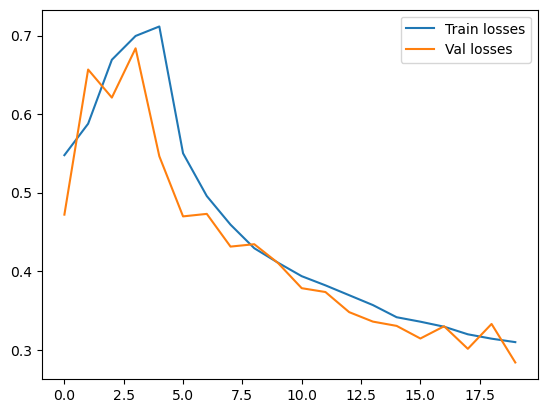

In [45]:
show_losses(s_train_loss, s_val_loss, 20)

In [46]:
def performance_loader(model, loader):
    preds_p = torch.tensor([]).to(device)
    labels_p = torch.tensor([]).to(device)

    with torch.no_grad():
        for img, labels in loader:
            img = img.to(device)
            labels = labels.to(device)
            preds = model(img)
            
            preds_p_temp = process_predictions(preds)
            preds_p = torch.cat((preds_p, preds_p_temp),0)
            labels_p = torch.cat((labels_p, labels),0)
            
        performance = final_acc_iou(preds_p, labels_p)
    return performance, preds_p
    

In [77]:
p_ , preds_p = performance_loader(shallow, train_loader)

Average p_c accuracy: 0.951
Average bbox_iou: 0.360
Average label_acc: 0.951
Combined: 0.754


In [47]:
p_ , preds_p = performance_loader(shallow, val_loader)

Average p_c accuracy: 0.948
Average bbox_iou: 0.432
Average label_acc: 0.951
Combined: 0.777


In [48]:
preds_g = convert_to_global(preds_p)

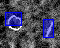

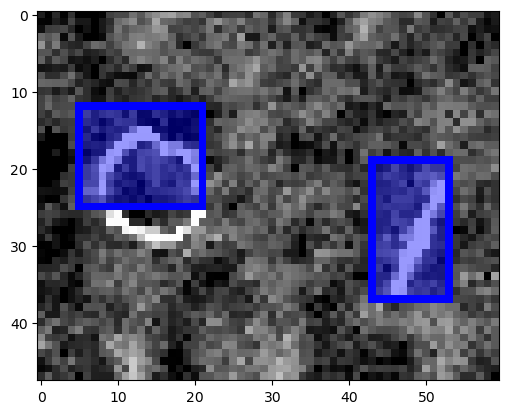

In [49]:
draw_bounding(val_data, preds_g, 0, local=False)

## Final training experiment and comparison

In [50]:
torch.manual_seed(seed)
shallow = ShallowCNN().to(device)
torch.manual_seed(seed)
medium = MediumCNN().to(device)
torch.manual_seed(seed)
deep = DeepCNN().to(device)

torch.manual_seed(seed)
medium_bn = MediumCNN_bn().to(device)
torch.manual_seed(seed)
deep_bn = DeepCNN_bn().to(device)

In [51]:
models = [shallow, medium, deep, medium_bn, deep_bn] # add resnet? shallow, medium, deep,   medium_bn, deep_bn
lossfns = [detection_loss_with_l1, detection_loss_with_mse]

In [52]:
torch.manual_seed(seed)

def run_all_models(models, lossfn):
    all_losses = {}
    all_performances = {}
    for model in models:
        
        model = model.to(device)
        optim = torch.optim.Adam(model.parameters(), lr=0.001)

        model_name = type(model).__name__

        print('\nNow testing', model_name)

        all_losses[model_name] = train(30, optim, detection_loss_with_l1, model, train_loader, val_loader)

        val_preds_p = torch.tensor([]).to(device)
        labels_tot = torch.tensor([]).to(device)

        #To make the validation faster and prevent hogging of vram it is better to use a dataloader than to send the dataset to device
        #final_acc_iou is implemented to print score. Could change it to only return values and have a verbose argument instead.
        #To make this work with dataloader, we need to process the data to match, and then add the tensor to the total tensor
        #Then compute final acc
        with torch.no_grad():
            for img, labels in val_loader:
                img = img.to(device)
                labels = labels.to(device)
                val_preds = model(img)
                
                val_preds_p_temp = process_predictions(val_preds)
                val_preds_p = torch.cat((val_preds_p, val_preds_p_temp),0)
                labels_tot = torch.cat((labels_tot, labels),0)
                
            all_performances[model_name] = final_acc_iou(val_preds_p, labels_tot)
        
        print('Done training\n')
        '''
        with open(f'{model_name}.pkl', 'wb') as f:
            pickle.dump(model, f)
        '''

    return all_losses, all_performances

In [53]:
def show_losses(train_losses, val_losses, num_epochs):
    plt.plot(range(num_epochs), train_losses)
    plt.plot(range(num_epochs), val_losses)
    plt.legend(['Train losses', 'Val losses'])
    

In [54]:
results = run_all_models(models, lossfns)


Now testing ShallowCNN


Epoch: 1: 100%|██████████| 209/209 [00:00<00:00, 216.37batch/s]


Epoch: 1, Train loss:  0.542, Val loss:  0.466


Epoch: 2: 100%|██████████| 209/209 [00:01<00:00, 179.52batch/s]


Epoch: 2, Train loss:  0.560, Val loss:  0.552


Epoch: 3: 100%|██████████| 209/209 [00:01<00:00, 167.01batch/s]


Epoch: 3, Train loss:  0.619, Val loss:  0.621


Epoch: 4: 100%|██████████| 209/209 [00:01<00:00, 176.51batch/s]


Epoch: 4, Train loss:  0.680, Val loss:  0.689


Epoch: 5: 100%|██████████| 209/209 [00:01<00:00, 172.27batch/s]


Epoch: 5, Train loss:  0.570, Val loss:  0.468


Epoch: 6: 100%|██████████| 209/209 [00:01<00:00, 174.93batch/s]


Epoch: 6, Train loss:  0.476, Val loss:  0.436


Epoch: 7: 100%|██████████| 209/209 [00:01<00:00, 175.15batch/s]


Epoch: 7, Train loss:  0.439, Val loss:  0.448


Epoch: 8: 100%|██████████| 209/209 [00:01<00:00, 172.48batch/s]


Epoch: 8, Train loss:  0.414, Val loss:  0.381


Epoch: 9: 100%|██████████| 209/209 [00:01<00:00, 176.19batch/s]


Epoch: 9, Train loss:  0.392, Val loss:  0.384


Epoch: 10: 100%|██████████| 209/209 [00:01<00:00, 178.21batch/s]


Epoch: 10, Train loss:  0.381, Val loss:  0.367


Epoch: 11: 100%|██████████| 209/209 [00:01<00:00, 176.71batch/s]


Epoch: 11, Train loss:  0.364, Val loss:  0.366


Epoch: 12: 100%|██████████| 209/209 [00:01<00:00, 177.59batch/s]


Epoch: 12, Train loss:  0.354, Val loss:  0.406


Epoch: 13: 100%|██████████| 209/209 [00:01<00:00, 177.63batch/s]


Epoch: 13, Train loss:  0.347, Val loss:  0.371


Epoch: 14: 100%|██████████| 209/209 [00:01<00:00, 178.46batch/s]


Epoch: 14, Train loss:  0.336, Val loss:  0.333


Epoch: 15: 100%|██████████| 209/209 [00:01<00:00, 174.07batch/s]


Epoch: 15, Train loss:  0.327, Val loss:  0.329


Epoch: 16: 100%|██████████| 209/209 [00:01<00:00, 175.28batch/s]


Epoch: 16, Train loss:  0.326, Val loss:  0.360


Epoch: 17: 100%|██████████| 209/209 [00:01<00:00, 175.96batch/s]


Epoch: 17, Train loss:  0.320, Val loss:  0.343


Epoch: 18: 100%|██████████| 209/209 [00:01<00:00, 177.03batch/s]


Epoch: 18, Train loss:  0.313, Val loss:  0.328


Epoch: 19: 100%|██████████| 209/209 [00:01<00:00, 180.06batch/s]


Epoch: 19, Train loss:  0.305, Val loss:  0.320


Epoch: 20: 100%|██████████| 209/209 [00:01<00:00, 182.88batch/s]


Epoch: 20, Train loss:  0.303, Val loss:  0.339


Epoch: 21: 100%|██████████| 209/209 [00:01<00:00, 186.35batch/s]


Epoch: 21, Train loss:  0.299, Val loss:  0.306


Epoch: 22: 100%|██████████| 209/209 [00:01<00:00, 186.83batch/s]


Epoch: 22, Train loss:  0.296, Val loss:  0.303


Epoch: 23: 100%|██████████| 209/209 [00:01<00:00, 185.38batch/s]


Epoch: 23, Train loss:  0.292, Val loss:  0.301


Epoch: 24: 100%|██████████| 209/209 [00:01<00:00, 184.75batch/s]


Epoch: 24, Train loss:  0.291, Val loss:  0.298


Epoch: 25: 100%|██████████| 209/209 [00:01<00:00, 185.01batch/s]


Epoch: 25, Train loss:  0.287, Val loss:  0.289


Epoch: 26: 100%|██████████| 209/209 [00:01<00:00, 186.48batch/s]


Epoch: 26, Train loss:  0.282, Val loss:  0.303


Epoch: 27: 100%|██████████| 209/209 [00:01<00:00, 184.22batch/s]


Epoch: 27, Train loss:  0.280, Val loss:  0.278


Epoch: 28: 100%|██████████| 209/209 [00:01<00:00, 183.77batch/s]


Epoch: 28, Train loss:  0.277, Val loss:  0.304


Epoch: 29: 100%|██████████| 209/209 [00:01<00:00, 180.39batch/s]


Epoch: 29, Train loss:  0.273, Val loss:  0.302


Epoch: 30: 100%|██████████| 209/209 [00:01<00:00, 185.24batch/s]


Epoch: 30, Train loss:  0.271, Val loss:  0.279
Average p_c accuracy: 0.951
Average bbox_iou: 0.360
Average label_acc: 0.949
Combined: 0.754
Done training


Now testing MediumCNN


Epoch: 1: 100%|██████████| 209/209 [00:01<00:00, 129.01batch/s]


Epoch: 1, Train loss:  0.583, Val loss:  0.528


Epoch: 2: 100%|██████████| 209/209 [00:01<00:00, 120.71batch/s]


Epoch: 2, Train loss:  0.714, Val loss:  0.654


Epoch: 3: 100%|██████████| 209/209 [00:01<00:00, 119.59batch/s]


Epoch: 3, Train loss:  0.620, Val loss:  0.541


Epoch: 4: 100%|██████████| 209/209 [00:01<00:00, 118.63batch/s]


Epoch: 4, Train loss:  0.560, Val loss:  0.541


Epoch: 5: 100%|██████████| 209/209 [00:01<00:00, 120.01batch/s]


Epoch: 5, Train loss:  0.531, Val loss:  0.486


Epoch: 6: 100%|██████████| 209/209 [00:01<00:00, 119.53batch/s]


Epoch: 6, Train loss:  0.396, Val loss:  0.303


Epoch: 7: 100%|██████████| 209/209 [00:01<00:00, 120.33batch/s]


Epoch: 7, Train loss:  0.315, Val loss:  0.286


Epoch: 8: 100%|██████████| 209/209 [00:01<00:00, 120.65batch/s]


Epoch: 8, Train loss:  0.285, Val loss:  0.244


Epoch: 9: 100%|██████████| 209/209 [00:01<00:00, 118.74batch/s]


Epoch: 9, Train loss:  0.266, Val loss:  0.298


Epoch: 10: 100%|██████████| 209/209 [00:01<00:00, 117.38batch/s]


Epoch: 10, Train loss:  0.254, Val loss:  0.250


Epoch: 11: 100%|██████████| 209/209 [00:01<00:00, 115.70batch/s]


Epoch: 11, Train loss:  0.245, Val loss:  0.287


Epoch: 12: 100%|██████████| 209/209 [00:01<00:00, 116.02batch/s]


Epoch: 12, Train loss:  0.235, Val loss:  0.228


Epoch: 13: 100%|██████████| 209/209 [00:01<00:00, 115.05batch/s]


Epoch: 13, Train loss:  0.217, Val loss:  0.221


Epoch: 14: 100%|██████████| 209/209 [00:01<00:00, 116.40batch/s]


Epoch: 14, Train loss:  0.215, Val loss:  0.228


Epoch: 15: 100%|██████████| 209/209 [00:01<00:00, 115.43batch/s]


Epoch: 15, Train loss:  0.204, Val loss:  0.212


Epoch: 16: 100%|██████████| 209/209 [00:01<00:00, 116.40batch/s]


Epoch: 16, Train loss:  0.199, Val loss:  0.201


Epoch: 17: 100%|██████████| 209/209 [00:01<00:00, 115.93batch/s]


Epoch: 17, Train loss:  0.188, Val loss:  0.189


Epoch: 18: 100%|██████████| 209/209 [00:01<00:00, 115.70batch/s]


Epoch: 18, Train loss:  0.186, Val loss:  0.203


Epoch: 19: 100%|██████████| 209/209 [00:01<00:00, 118.74batch/s]


Epoch: 19, Train loss:  0.176, Val loss:  0.229


Epoch: 20: 100%|██████████| 209/209 [00:01<00:00, 118.93batch/s]


Epoch: 20, Train loss:  0.167, Val loss:  0.176


Epoch: 21: 100%|██████████| 209/209 [00:01<00:00, 119.36batch/s]


Epoch: 21, Train loss:  0.156, Val loss:  0.173


Epoch: 22: 100%|██████████| 209/209 [00:01<00:00, 119.77batch/s]


Epoch: 22, Train loss:  0.149, Val loss:  0.172


Epoch: 23: 100%|██████████| 209/209 [00:01<00:00, 119.82batch/s]


Epoch: 23, Train loss:  0.144, Val loss:  0.156


Epoch: 24: 100%|██████████| 209/209 [00:01<00:00, 119.41batch/s]


Epoch: 24, Train loss:  0.141, Val loss:  0.184


Epoch: 25: 100%|██████████| 209/209 [00:01<00:00, 118.59batch/s]


Epoch: 25, Train loss:  0.135, Val loss:  0.157


Epoch: 26: 100%|██████████| 209/209 [00:01<00:00, 122.40batch/s]


Epoch: 26, Train loss:  0.128, Val loss:  0.166


Epoch: 27: 100%|██████████| 209/209 [00:01<00:00, 123.09batch/s]


Epoch: 27, Train loss:  0.128, Val loss:  0.161


Epoch: 28: 100%|██████████| 209/209 [00:01<00:00, 123.02batch/s]


Epoch: 28, Train loss:  0.128, Val loss:  0.177


Epoch: 29: 100%|██████████| 209/209 [00:01<00:00, 122.79batch/s]


Epoch: 29, Train loss:  0.120, Val loss:  0.164


Epoch: 30: 100%|██████████| 209/209 [00:01<00:00, 121.68batch/s]


Epoch: 30, Train loss:  0.122, Val loss:  0.163
Average p_c accuracy: 0.977
Average bbox_iou: 0.458
Average label_acc: 0.963
Combined: 0.799
Done training


Now testing DeepCNN


Epoch: 1: 100%|██████████| 209/209 [00:02<00:00, 73.83batch/s]


Epoch: 1, Train loss:  0.641, Val loss:  0.782


Epoch: 2: 100%|██████████| 209/209 [00:02<00:00, 70.17batch/s]


Epoch: 2, Train loss:  0.357, Val loss:  0.235


Epoch: 3: 100%|██████████| 209/209 [00:02<00:00, 70.25batch/s]


Epoch: 3, Train loss:  0.194, Val loss:  0.152


Epoch: 4: 100%|██████████| 209/209 [00:03<00:00, 68.73batch/s]


Epoch: 4, Train loss:  0.148, Val loss:  0.133


Epoch: 5: 100%|██████████| 209/209 [00:03<00:00, 68.85batch/s]


Epoch: 5, Train loss:  0.122, Val loss:  0.113


Epoch: 6: 100%|██████████| 209/209 [00:03<00:00, 68.79batch/s]


Epoch: 6, Train loss:  0.107, Val loss:  0.146


Epoch: 7: 100%|██████████| 209/209 [00:03<00:00, 68.36batch/s]


Epoch: 7, Train loss:  0.098, Val loss:  0.104


Epoch: 8: 100%|██████████| 209/209 [00:03<00:00, 68.84batch/s]


Epoch: 8, Train loss:  0.090, Val loss:  0.100


Epoch: 9: 100%|██████████| 209/209 [00:03<00:00, 68.76batch/s]


Epoch: 9, Train loss:  0.082, Val loss:  0.100


Epoch: 10: 100%|██████████| 209/209 [00:03<00:00, 68.00batch/s]


Epoch: 10, Train loss:  0.080, Val loss:  0.110


Epoch: 11: 100%|██████████| 209/209 [00:03<00:00, 68.48batch/s]


Epoch: 11, Train loss:  0.074, Val loss:  0.113


Epoch: 12: 100%|██████████| 209/209 [00:03<00:00, 68.62batch/s]


Epoch: 12, Train loss:  0.070, Val loss:  0.098


Epoch: 13: 100%|██████████| 209/209 [00:03<00:00, 68.59batch/s]


Epoch: 13, Train loss:  0.063, Val loss:  0.102


Epoch: 14: 100%|██████████| 209/209 [00:03<00:00, 68.62batch/s]


Epoch: 14, Train loss:  0.063, Val loss:  0.095


Epoch: 15: 100%|██████████| 209/209 [00:03<00:00, 68.62batch/s]


Epoch: 15, Train loss:  0.056, Val loss:  0.103


Epoch: 16: 100%|██████████| 209/209 [00:03<00:00, 68.62batch/s]


Epoch: 16, Train loss:  0.054, Val loss:  0.119


Epoch: 17: 100%|██████████| 209/209 [00:03<00:00, 68.26batch/s]


Epoch: 17, Train loss:  0.050, Val loss:  0.118


Epoch: 18: 100%|██████████| 209/209 [00:03<00:00, 68.17batch/s]


Epoch: 18, Train loss:  0.046, Val loss:  0.115


Epoch: 19: 100%|██████████| 209/209 [00:03<00:00, 68.16batch/s]


Epoch: 19, Train loss:  0.040, Val loss:  0.127


Epoch: 20: 100%|██████████| 209/209 [00:03<00:00, 68.18batch/s]


Epoch: 20, Train loss:  0.033, Val loss:  0.140


Epoch: 21: 100%|██████████| 209/209 [00:03<00:00, 68.93batch/s]


Epoch: 21, Train loss:  0.035, Val loss:  0.161


Epoch: 22: 100%|██████████| 209/209 [00:03<00:00, 68.51batch/s]


Epoch: 22, Train loss:  0.033, Val loss:  0.151


Epoch: 23: 100%|██████████| 209/209 [00:03<00:00, 68.22batch/s]


Epoch: 23, Train loss:  0.025, Val loss:  0.133


Epoch: 24: 100%|██████████| 209/209 [00:03<00:00, 68.06batch/s]


Epoch: 24, Train loss:  0.024, Val loss:  0.136


Epoch: 25: 100%|██████████| 209/209 [00:03<00:00, 68.45batch/s]


Epoch: 25, Train loss:  0.021, Val loss:  0.162


Epoch: 26: 100%|██████████| 209/209 [00:03<00:00, 68.36batch/s]


Epoch: 26, Train loss:  0.035, Val loss:  0.146


Epoch: 27: 100%|██████████| 209/209 [00:03<00:00, 67.98batch/s]


Epoch: 27, Train loss:  0.019, Val loss:  0.155


Epoch: 28: 100%|██████████| 209/209 [00:03<00:00, 68.40batch/s]


Epoch: 28, Train loss:  0.018, Val loss:  0.162


Epoch: 29: 100%|██████████| 209/209 [00:03<00:00, 68.71batch/s]


Epoch: 29, Train loss:  0.011, Val loss:  0.165


Epoch: 30: 100%|██████████| 209/209 [00:03<00:00, 68.48batch/s]


Epoch: 30, Train loss:  0.011, Val loss:  0.193
Average p_c accuracy: 0.986
Average bbox_iou: 0.643
Average label_acc: 0.979
Combined: 0.869
Done training


Now testing MediumCNN_bn


Epoch: 1: 100%|██████████| 209/209 [00:02<00:00, 100.15batch/s]


Epoch: 1, Train loss:  0.620, Val loss:  0.467


Epoch: 2: 100%|██████████| 209/209 [00:02<00:00, 97.44batch/s]


Epoch: 2, Train loss:  0.542, Val loss:  0.619


Epoch: 3: 100%|██████████| 209/209 [00:02<00:00, 97.66batch/s]


Epoch: 3, Train loss:  0.398, Val loss:  0.930


Epoch: 4: 100%|██████████| 209/209 [00:02<00:00, 98.39batch/s]


Epoch: 4, Train loss:  0.316, Val loss:  0.819


Epoch: 5: 100%|██████████| 209/209 [00:02<00:00, 97.96batch/s]


Epoch: 5, Train loss:  0.269, Val loss:  1.146


Epoch: 6: 100%|██████████| 209/209 [00:02<00:00, 98.45batch/s]


Epoch: 6, Train loss:  0.239, Val loss:  0.999


Epoch: 7: 100%|██████████| 209/209 [00:02<00:00, 98.33batch/s]


Epoch: 7, Train loss:  0.209, Val loss:  0.932


Epoch: 8: 100%|██████████| 209/209 [00:02<00:00, 97.58batch/s]


Epoch: 8, Train loss:  0.191, Val loss:  1.416


Epoch: 9: 100%|██████████| 209/209 [00:02<00:00, 97.28batch/s]


Epoch: 9, Train loss:  0.176, Val loss:  1.121


Epoch: 10: 100%|██████████| 209/209 [00:02<00:00, 97.57batch/s]


Epoch: 10, Train loss:  0.163, Val loss:  1.599


Epoch: 11: 100%|██████████| 209/209 [00:02<00:00, 97.21batch/s]


Epoch: 11, Train loss:  0.152, Val loss:  1.440


Epoch: 12: 100%|██████████| 209/209 [00:02<00:00, 96.32batch/s]


Epoch: 12, Train loss:  0.148, Val loss:  1.934


Epoch: 13: 100%|██████████| 209/209 [00:02<00:00, 97.15batch/s]


Epoch: 13, Train loss:  0.140, Val loss:  2.013


Epoch: 14: 100%|██████████| 209/209 [00:02<00:00, 97.71batch/s]


Epoch: 14, Train loss:  0.135, Val loss:  2.201


Epoch: 15: 100%|██████████| 209/209 [00:02<00:00, 97.92batch/s]


Epoch: 15, Train loss:  0.127, Val loss:  2.637


Epoch: 16: 100%|██████████| 209/209 [00:02<00:00, 97.07batch/s]


Epoch: 16, Train loss:  0.123, Val loss:  2.044


Epoch: 17: 100%|██████████| 209/209 [00:02<00:00, 97.54batch/s]


Epoch: 17, Train loss:  0.117, Val loss:  2.507


Epoch: 18: 100%|██████████| 209/209 [00:02<00:00, 97.32batch/s]


Epoch: 18, Train loss:  0.110, Val loss:  1.986


Epoch: 19: 100%|██████████| 209/209 [00:02<00:00, 97.38batch/s]


Epoch: 19, Train loss:  0.108, Val loss:  2.282


Epoch: 20: 100%|██████████| 209/209 [00:02<00:00, 97.28batch/s]


Epoch: 20, Train loss:  0.103, Val loss:  2.301


Epoch: 21: 100%|██████████| 209/209 [00:02<00:00, 97.59batch/s]


Epoch: 21, Train loss:  0.098, Val loss:  1.674


Epoch: 22: 100%|██████████| 209/209 [00:02<00:00, 97.23batch/s]


Epoch: 22, Train loss:  0.099, Val loss:  1.610


Epoch: 23: 100%|██████████| 209/209 [00:02<00:00, 97.36batch/s]


Epoch: 23, Train loss:  0.092, Val loss:  1.942


Epoch: 24: 100%|██████████| 209/209 [00:02<00:00, 96.75batch/s]


Epoch: 24, Train loss:  0.089, Val loss:  2.994


Epoch: 25: 100%|██████████| 209/209 [00:02<00:00, 97.66batch/s]


Epoch: 25, Train loss:  0.089, Val loss:  2.379


Epoch: 26: 100%|██████████| 209/209 [00:02<00:00, 97.98batch/s]


Epoch: 26, Train loss:  0.082, Val loss:  3.721


Epoch: 27: 100%|██████████| 209/209 [00:02<00:00, 97.20batch/s]


Epoch: 27, Train loss:  0.079, Val loss:  2.694


Epoch: 28: 100%|██████████| 209/209 [00:02<00:00, 96.19batch/s]


Epoch: 28, Train loss:  0.079, Val loss:  3.298


Epoch: 29: 100%|██████████| 209/209 [00:02<00:00, 97.54batch/s]


Epoch: 29, Train loss:  0.073, Val loss:  3.173


Epoch: 30: 100%|██████████| 209/209 [00:02<00:00, 97.59batch/s]


Epoch: 30, Train loss:  0.071, Val loss:  3.153
Average p_c accuracy: 0.805
Average bbox_iou: 0.197
Average label_acc: 0.703
Combined: 0.568
Done training


Now testing DeepCNN_bn


Epoch: 1: 100%|██████████| 209/209 [00:03<00:00, 57.67batch/s]


Epoch: 1, Train loss:  0.394, Val loss:  1.719


Epoch: 2: 100%|██████████| 209/209 [00:03<00:00, 57.48batch/s]


Epoch: 2, Train loss:  0.159, Val loss:  1.287


Epoch: 3: 100%|██████████| 209/209 [00:03<00:00, 57.81batch/s]


Epoch: 3, Train loss:  0.124, Val loss:  1.391


Epoch: 4: 100%|██████████| 209/209 [00:03<00:00, 58.24batch/s]


Epoch: 4, Train loss:  0.102, Val loss:  1.667


Epoch: 5: 100%|██████████| 209/209 [00:03<00:00, 58.08batch/s]


Epoch: 5, Train loss:  0.097, Val loss:  1.744


Epoch: 6: 100%|██████████| 209/209 [00:03<00:00, 58.37batch/s]


Epoch: 6, Train loss:  0.084, Val loss:  2.260


Epoch: 7: 100%|██████████| 209/209 [00:03<00:00, 58.24batch/s]


Epoch: 7, Train loss:  0.068, Val loss:  1.659


Epoch: 8: 100%|██████████| 209/209 [00:03<00:00, 58.29batch/s]


Epoch: 8, Train loss:  0.061, Val loss:  1.980


Epoch: 9: 100%|██████████| 209/209 [00:03<00:00, 58.38batch/s]


Epoch: 9, Train loss:  0.058, Val loss:  1.760


Epoch: 10: 100%|██████████| 209/209 [00:03<00:00, 58.00batch/s]


Epoch: 10, Train loss:  0.044, Val loss:  2.364


Epoch: 11: 100%|██████████| 209/209 [00:03<00:00, 58.03batch/s]


Epoch: 11, Train loss:  0.036, Val loss:  1.569


Epoch: 12: 100%|██████████| 209/209 [00:03<00:00, 58.22batch/s]


Epoch: 12, Train loss:  0.027, Val loss:  1.942


Epoch: 13: 100%|██████████| 209/209 [00:03<00:00, 57.97batch/s]


Epoch: 13, Train loss:  0.026, Val loss:  2.475


Epoch: 14: 100%|██████████| 209/209 [00:03<00:00, 58.27batch/s]


Epoch: 14, Train loss:  0.025, Val loss:  2.555


Epoch: 15: 100%|██████████| 209/209 [00:03<00:00, 58.20batch/s]


Epoch: 15, Train loss:  0.021, Val loss:  2.840


Epoch: 16: 100%|██████████| 209/209 [00:03<00:00, 58.07batch/s]


Epoch: 16, Train loss:  0.017, Val loss:  4.208


Epoch: 17: 100%|██████████| 209/209 [00:03<00:00, 56.64batch/s]


Epoch: 17, Train loss:  0.022, Val loss:  3.001


Epoch: 18: 100%|██████████| 209/209 [00:03<00:00, 55.28batch/s]


Epoch: 18, Train loss:  0.012, Val loss:  2.743


Epoch: 19: 100%|██████████| 209/209 [00:03<00:00, 56.32batch/s]


Epoch: 19, Train loss:  0.006, Val loss:  2.403


Epoch: 20: 100%|██████████| 209/209 [00:03<00:00, 56.52batch/s]


Epoch: 20, Train loss:  0.003, Val loss:  2.561


Epoch: 21: 100%|██████████| 209/209 [00:03<00:00, 56.10batch/s]


Epoch: 21, Train loss:  0.002, Val loss:  2.575


Epoch: 22: 100%|██████████| 209/209 [00:03<00:00, 57.03batch/s]


Epoch: 22, Train loss:  0.002, Val loss:  2.581


Epoch: 23: 100%|██████████| 209/209 [00:03<00:00, 56.43batch/s]


Epoch: 23, Train loss:  0.002, Val loss:  2.639


Epoch: 24: 100%|██████████| 209/209 [00:03<00:00, 55.00batch/s]


Epoch: 24, Train loss:  0.002, Val loss:  2.643


Epoch: 25: 100%|██████████| 209/209 [00:03<00:00, 57.58batch/s]


Epoch: 25, Train loss:  0.002, Val loss:  2.735


Epoch: 26: 100%|██████████| 209/209 [00:03<00:00, 56.40batch/s]


Epoch: 26, Train loss:  0.002, Val loss:  2.717


Epoch: 27: 100%|██████████| 209/209 [00:03<00:00, 56.94batch/s]


Epoch: 27, Train loss:  0.002, Val loss:  2.896


Epoch: 28: 100%|██████████| 209/209 [00:03<00:00, 56.28batch/s]


Epoch: 28, Train loss:  0.001, Val loss:  2.908


Epoch: 29: 100%|██████████| 209/209 [00:03<00:00, 56.38batch/s]


Epoch: 29, Train loss:  0.001, Val loss:  2.850


Epoch: 30: 100%|██████████| 209/209 [00:03<00:00, 56.43batch/s]


Epoch: 30, Train loss:  0.001, Val loss:  2.943
Average p_c accuracy: 0.429
Average bbox_iou: 0.046
Average label_acc: 0.570
Combined: 0.348
Done training



In [66]:
def plot_ax(ax, plots:list, plot_titles:list, title):
    for i in range(len(plots)):
        ax.plot(plots[i], label= plot_titles[i])
        ax.legend()
    ax.set_title(title)

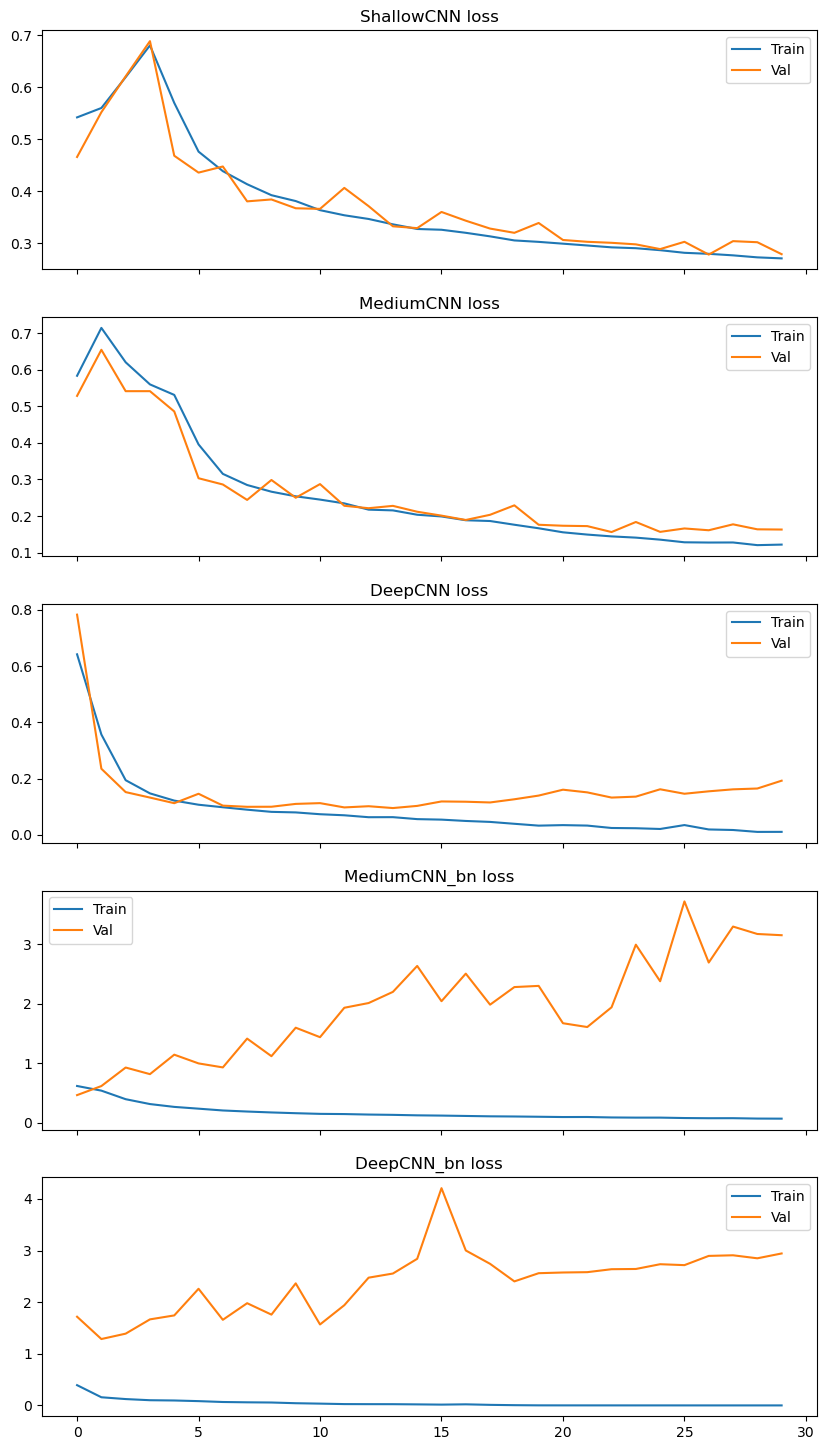

In [67]:
model_names = [type(model).__name__ for model in models]

fig, ax = plt.subplots(len(model_names), 1, sharex=True, figsize=(10,18))

for i, ax in enumerate(ax.flatten()):
    plot_ax(ax, results[0][model_names[i]], ['Train', 'Val'], title=f'{model_names[i]} loss')



In [68]:
#Quick sanity check. It should be 1 for all metrices. 
with torch.no_grad():
    final_acc_iou(val_labels_p, val_labels_p)

Average p_c accuracy: 1.000
Average bbox_iou: 1.000
Average label_acc: 1.000
Combined: 1.000


In [69]:
model_dict = {}
for i, model_name in enumerate(model_names):
    model_dict[model_name] = models[i]

In [70]:
#Finding best model
best_model_name, score = max(results[1].items(), key= lambda x: x[1])

In [71]:
best_model = model_dict[best_model_name]

In [74]:
test_loader = DataLoader(test_dataset, batch_size=128)

print('The best model is:', best_model_name, '\nNow lets see the performance')

print('\nTraining performance')
performance_loader(best_model, train_loader)

print('\nValidation performance')
performance_loader(best_model, val_loader)

print('\nTest performance')
test_results = performance_loader(best_model, test_loader)

The best model is: DeepCNN 
Now lets see the performance

Training performance
Average p_c accuracy: 0.999
Average bbox_iou: 0.664
Average label_acc: 1.000
Combined: 0.888

Validation performance
Average p_c accuracy: 0.986
Average bbox_iou: 0.643
Average label_acc: 0.979
Combined: 0.869

Test performance
Average p_c accuracy: 0.985
Average bbox_iou: 0.641
Average label_acc: 0.980
Combined: 0.869


In [75]:
test_results_global = convert_to_global(test_results[1])

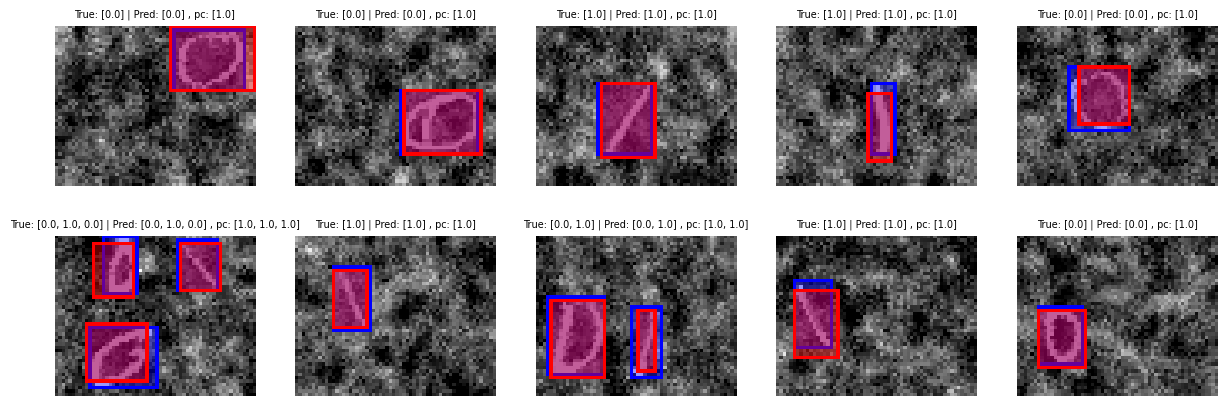

In [76]:
#Number of images
n=10

#Creating subplots
fig, ax = plt.subplots(int(n/5), 5, sharex=True, figsize=(15,5))

#For every subplot, plot the image with relevant information
for i, ax in enumerate(ax.flatten()):
    ax.imshow(draw_bounding(test_data, test_labels_g, i, local=False, predictions=test_results_global, show_img=False))
    
    #Convert the list to a tensor, so it is easier to index
    pred_result = torch.stack(test_results_global[i]).clone()
    true_result = torch.stack(test_labels_g[i]).clone()

    pred_result[pred_result[:,0] < 0.5] = -1.

    #Set the title to relevant information
    ax.set_title(f'True: {true_result[:,5].tolist()} | Pred: {pred_result[:,5].tolist()} , pc: {pred_result[:,0].tolist()}', fontsize=7)
    
    ax.axis('off')

In [ ]:
#The results are pretty good. Not perfect bounding boxes, but around the same place and size.